In [1]:
import pandas as pd
import talib
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import iisignature
from tqdm import tqdm  # For progress bar
from features import construct_features
from signature_feature import create_signature_features 

In [2]:
btc_df = pd.read_csv('BTCUSDC-1m-2years.csv') 

In [3]:
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'],dayfirst=True )
btc_df.set_index('timestamp', inplace=True)

In [4]:
btc_df

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,ignore
timestamp,,,,,,,,,,,,
2024-01-01 00:00:00,1704067200000,42274.27,42291.22,42255.49,42286.97,0.42926,1704067259999,18143.726615,20,0.41173,17402.724821,0
2024-01-01 00:01:00,1704067260000,42293.21,42314.41,42293.21,42314.41,0.07881,1704067319999,3333.991560,15,0.06083,2573.427464,0
2024-01-01 00:02:00,1704067320000,42311.52,42324.75,42310.81,42313.19,0.75971,1704067379999,32149.032673,22,0.63288,26781.946400,0
2024-01-01 00:03:00,1704067380000,42321.14,42357.01,42321.14,42357.01,0.35064,1704067439999,14846.349183,29,0.28116,11904.935498,0
2024-01-01 00:04:00,1704067440000,42357.02,42390.63,42357.02,42390.63,1.99094,1704067499999,84362.396140,37,1.95944,83027.392961,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-30 23:55:00,1759276500000000,114073.37,114073.40,114073.36,114073.40,0.82091,1759276559999999,93643.969330,41,0.70909,80888.285952,0
2025-09-30 23:56:00,1759276560000000,114073.40,114077.15,114073.40,114077.15,0.01677,1759276619999999,1913.051094,38,0.01668,1902.784151,0
2025-09-30 23:57:00,1759276620000000,114077.15,114086.00,114077.15,114086.00,0.87074,1759276679999999,99337.073418,105,0.57368,65446.689228,0


In [5]:
new_df = construct_features(btc_df)
sig_features = create_signature_features(btc_df, window_size=100, level=2)
new_df = pd.concat([new_df, sig_features], axis=1)

Computing Rolling Signatures (Window: 100, Level: 2)...


100%|██████████| 920060/920060 [00:24<00:00, 37370.42it/s]


In [6]:
print(new_df.head())
new_df.columns.to_list()

                     open_lag_1  high_lag_1  low_lag_1  close_lag_1  \
timestamp                                                             
2024-01-01 00:00:00         NaN         NaN        NaN          NaN   
2024-01-01 00:01:00    42274.27    42291.22   42255.49     42286.97   
2024-01-01 00:02:00    42293.21    42314.41   42293.21     42314.41   
2024-01-01 00:03:00    42311.52    42324.75   42310.81     42313.19   
2024-01-01 00:04:00    42321.14    42357.01   42321.14     42357.01   

                     number_of_trades_lag_1  quote_asset_volume_lag_1  \
timestamp                                                               
2024-01-01 00:00:00                     NaN                       NaN   
2024-01-01 00:01:00                    20.0              18143.726615   
2024-01-01 00:02:00                    15.0               3333.991560   
2024-01-01 00:03:00                    22.0              32149.032673   
2024-01-01 00:04:00                    29.0              14846.3

['open_lag_1',
 'high_lag_1',
 'low_lag_1',
 'close_lag_1',
 'number_of_trades_lag_1',
 'quote_asset_volume_lag_1',
 'taker_buy_quote_volume_lag_1',
 'volume_lag_1',
 'HminusL',
 'return_lag_1',
 'return_lag_2',
 'return_lag_3',
 'return_lag_4',
 'return_lag_5',
 'SMA',
 'correlation_sma_close',
 'sum3',
 'sum5',
 'sum3-sum5',
 'target',
 'RSI9',
 'RSI14',
 'RSI9Smaller20',
 'RSI14Smaller20',
 'RSI9Bigger80',
 'MACD1',
 'MACD2',
 'MACD3',
 'roc9',
 'roc14',
 'ewa',
 'mom5',
 'WilliamR',
 'doubleEMA',
 'Sig_0',
 'Sig_1',
 'Sig_2',
 'Sig_3',
 'Sig_4',
 'Sig_5']

In [7]:
new_df.dropna(inplace=True)

In [8]:
Y = new_df['target']
X = new_df.drop(columns = 'target')

In [9]:
from scipy import stats

corr = pd.DataFrame()
corr.index = X.columns
for col in X.columns:
    st = stats.pearsonr(X[col], Y)
    corr.loc[col, 'corr'] = st.statistic
    corr.loc[col, 'pvalue'] = st.pvalue

corr.sort_values(key = lambda x: np.abs(x), by='corr', ascending=False)

/var/folders/1v/pvjy8h9d63x_z46tqdpl7p4h0000gn/T/ipykernel_14481/2731194731.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  st = stats.pearsonr(X[col], Y)
/var/folders/1v/pvjy8h9d63x_z46tqdpl7p4h0000gn/T/ipykernel_14481/2731194731.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  st = stats.pearsonr(X[col], Y)


,corr,pvalue
sum3,-0.015150,7.514121e-48
roc14,-0.014802,9.353777e-46
roc9,-0.013936,9.286328e-41
HminusL,0.013718,1.509834e-39
MACD1,-0.013307,2.583812e-37
return_lag_1,-0.013144,1.899170e-36
sum5,-0.012364,1.917509e-32
RSI9Smaller20,0.012189,1.406219e-31
RSI14,-0.012129,2.738534e-31
Sig_3,-0.012045,7.076734e-31


In [ ]:
X_train, y_train = X[:795000], Y[:795000]
X_eval, y_eval = X[800000:845000], Y[800000:845000]
X_test, y_test = X[850000:], Y[850000:]

In [11]:
params={'learning_rate': 0.001,
        'max_depth': 8,
        'n_jobs': -1,
        'early_stopping_round':500,
        'random_state':42,
        'n_estimators':10000,
        'max_depth':64,
        #'objective': 'accuracy',
        'feature_fraction':0.5,
        #'reg_alpha':100,
        #'max_depth':-1,
        #'reg_lambda':1,
        #'lambda_l2':3.0,        
        #'lambda_l1':0.5,
        'bagging_fraction':0.5,
        'bagging_freq':2,
        'min_data_in_leaf': 20
        #'boosting_type':''
        }
LGBMmodel=LGBMClassifier(**params)
        
LGBMmodel.fit(X_train, y_train, eval_set=[(X_eval, y_eval)])

y_pred = LGBMmodel.predict(X_test)
        
print("LGBM Accuracy: ",accuracy_score(y_test, y_pred))

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 371516, number of ne

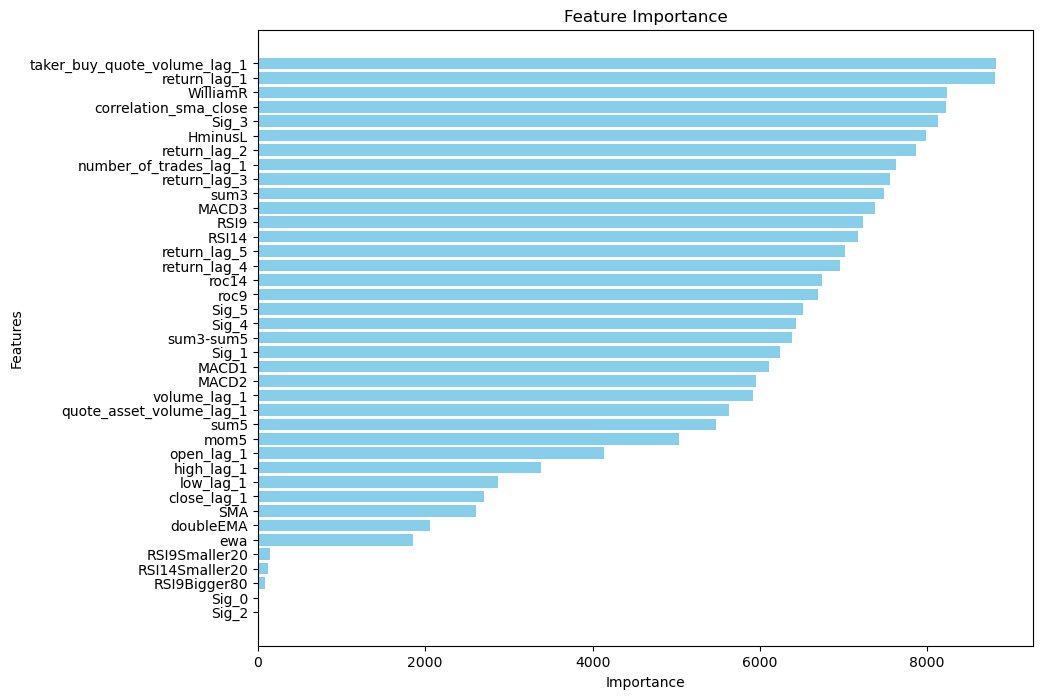

In [12]:
import matplotlib.pyplot as plt

# Extract feature importance from the LightGBM model
feature_importances = LGBMmodel.feature_importances_
features = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()